In [24]:
import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

In [25]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [6]:
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LK.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]


In [7]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

In [8]:
print(LK.shape, len(pred))
acc = model.score_
print(acc)

(610, 1379) 610
0.136


In [9]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (102.0, 648.0, 0.1574074074074074, 0.37777777777777777, 0.9876770942283921, 0.136, 0.9967757412916227, 0.864, 0.6222222222222222)


# Mutual information maximizer (MIM)

In [72]:
def getTrainTest(split_y, split_x, i:int, kfold:int):
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))

    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))

    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])

    x_train = x_train.T
    
    return x_train, y_train, x_test, y_test

In [77]:
def MIM_CV(y:np.array,x:np.array, Model: Callable, Scoring: Callable, maximize:bool, kfold:int, plot:bool):
    """ Calculate the mutual information and select the ones which has more information gain. CV to determine best subset.
  
      parameters:
      y : np.array,
        family of each data points
      x : np.array,
        features of each data points
      Model : Callable,
        the model is fitted using this method
      Scoring: Callable,
        scoring function use to evaluate the model
      maximize: bool,
        if True the scoring function is maximize, else it is minimize
      kfold: int,
        number of folds for CV
      print : bool (default = False),
        if true print the mean/std training and testing score
        

      returns:
      final_subset : np.array,
        subset of features with the best score
      best_test_score : float,
        test score obtained with the best subset of features """
    
    #Store score training and best subset
    score_training = []
    score_testing = []
    final_subset = []
    
    #Split the data in kfold
    split_x, split_y = split_data_cv(x,y,kfold)
    
    for i in range(0,kfold):
        print(i)
        #Get split data
        x_train, y_train, x_test, y_test = getTrainTest(split_y, split_x, i,kfold)
        
        #Run feature selection on training set
        N = np.arange(80,1300,30)
        subset, score = MIM(y_train, x_train, FamiliesClusters, compute_precision,True,N, 3, plot=True)
        
        #Evaluate subset on test set
        x_subset = x_test[:, subset]
        test_score = evaluate(y_test,x_subset,Model,Scoring,maximize)
        
        #Store best score on current folds
        score_training.append(score)
        score_testing.append(test_score)
        if (len(final_subset) == 0 or np.argmax(score_testing) == i): #if the last best test score is best overall keep subset as the finals subset
            final_subset = subset
        
    return final_subset, score_training, score_testing

0
1
2
3
4
test 0.3461849011203849 0.05303586493310167
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (102.0, 648.0, 0.1574074074074074, 0.37777777777777777, 0.9876770942283921, 0.136, 0.9967757412916227, 0.864, 0.6222222222222222)


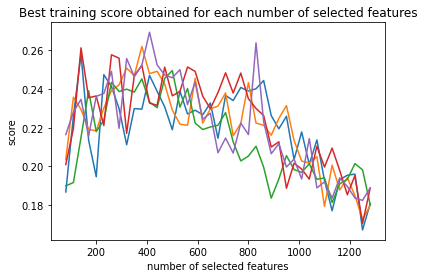

In [79]:
kwargs = []
subset, score_training, score_testing = MIM_CV(y,LK, FamiliesClusters, compute_precision,True, 5, True)
mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Anova F test

In [ ]:
def ANOVA_CV(y:np.array,x:np.array, Model: Callable, Scoring: Callable, maximize:bool, N:np.array, kfold:int, plot:bool = False):
    """ Calculate the ANOVA test and select the ones with larger score. CV the result.
  
      parameters:
      y : np.array,
        family of each data points
      x : np.array,
        features of each data points
      Model : Callable,
        the model is fitted using this method
      Scoring: Callable,
        scoring function use to evaluate the model
      maximize: bool,
        if True the scoring function is maximize, else it is minimize
      N: np.array,
          number of features to keep, will chose the best number out of entry in the N array
      kfold: int,
        number of folds for CV
      plot : bool (defaul = False),
        if true plot the accuracy vs the number of selected features
        

      returns:
      final_subset : np.array,
        subset of features with the best score
      best_test_score : float,
        test score obtained with the best subset of features """
    
     #Store scores
    best_score_test = []
    final_subset = []
    
    #Split the data in kfold
    split_x, split_y = split_data_cv(x,y,kfold)
    
    for i in range(0,kfold):
        score_test = []
        
        print(i)
        #Get split data
        x_test = np.squeeze(split_x[i])
        y_test = np.squeeze(split_y[i])
        x_train_temp = np.squeeze(np.delete(split_x, i))
        y_train_temp = np.squeeze(np.delete(split_y, i))

        #Fuse the training fold
        for j in range(0,kfold-1):
            x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
            y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))

        x_train = x_train_temp[0].T
        y_train = y_train_temp[0]
        for j in range(1,kfold-1):
            x_train = np.c_[x_train,x_train_temp[j].T]
            y_train = np.append(y_train,y_train_temp[j])

        x_train = x_train.T
        
        #Run feature selection on training set
        #Compute mutual information
        anova, _ = f_classif(x,y)
        index_sorted  = np.argsort(anova)
        
        best_subset, best_score = None, None
        for i in N:
            #Define the subset with i features
            subset = index_sorted[-i :]

            #Evaluate the error on given subset on test data
            x_subset = x_test[:, subset]
            score = evaluate(y_test,x_subset,Model,Scoring,maximize)
            if ((best_score == None) or (maximize==True and score > best_score) or (maximize ==False and score < best_score)):
                #Convert best_subset into features indices
                best_subset = np.sort(subset)
                best_score = score

            score_test.append(score)
    
        #Plot the score vs the number of selected features
        if(plot == True):
            plt.plot(N,score_test)
            plt.xlabel("number of selected features")
            plt.ylabel("score")
            plt.title("Best training score obtained for each number of selected features")
        
        #Store best score on current folds
        best_score_test.append(best_score)
        if (len(final_subset) == 0 or np.argmax(best_score_test) == i): #if the last best test score is best overall keep subset as the finals subset
            final_subset = best_subset
        
    return final_subset, best_test_score
    
    

In [ ]:
N = np.arange(80,1300,30)
subset, score_testing = ANOVA_CV(y,LK, FamiliesClusters, compute_precision,True,N, 5, plot=True)
mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = stimulated_annealing(y_train, x_train, FamiliesClusters, compute_sensitivity,True, 1400, 0.1, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

(485, 1379) (125, 1379) (485,) (125,)


# Genetic feature selection algorithm

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = genetic_fs(y_train,x_train,FamiliesClusters,compute_sensitivity,True, 500, 0.5, 0.2, 50, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Hybrid methods

# Mutual information and stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_stimulated_annealing(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([400]), 3, 5000, 0.05, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Mutual information and genetic feature selection

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_genetic_fs(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([700]), 3,  300, 0.5, 0.2, 120, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Baseline with preselected genes 

In [ ]:
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LSK.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]

In [ ]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

In [ ]:
print(LK.shape, len(pred))
acc = model.score_
print(acc)

In [ ]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Split data into Kfold (kfold = 5)

In [ ]:
split_x, split_y = split_data_cv(LK,y,5)

# Mutual information maximizer (MIM)

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = MIM(y_train, x_train, FamiliesClusters, compute_precision,True,N, 3, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Anova F test

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = ANOVA(y_train, x_train, FamiliesClusters, compute_ratio,True,N, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = stimulated_annealing(y_train, x_train, FamiliesClusters, compute_sensitivity,True, 1400, 0.1, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Genetic feature selection algorithm

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = genetic_fs(y_train,x_train,FamiliesClusters,compute_sensitivity,True, 500, 0.5, 0.2, 50, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Mutual information and stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_stimulated_annealing(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([400]), 3, 5000, 0.05, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Mutual information and genetic feature selection

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_genetic_fs(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([700]), 3,  300, 0.5, 0.2, 120, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)